In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

In [3]:
from torchvision.models import resnet18

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
class EmbedingModel(nn.Module):

    def __init__(self):
        super(EmbedingModel, self).__init__()
        resnet = resnet18(pretrained=True)
        self.feature_model = nn.Sequential(*list(resnet.children())[:-1])
        self.embeding_model = nn.Sequential(
            Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512)
        )
        self.full_model = nn.Sequential(self.feature_model, self.embeding_model)
        

    def forward(self, batch):
        im1 = batch[:, 0, :, :, :]
        im2 = batch[:, 1, :, :, :]
        im3 = batch[:, 2, :, :, :]
        im4 = batch[:, 3, :, :, :]
        emb1, emb2, emb3, emb4 = map(self.full_model, (im1, im2, im3, im4))
        emb = emb1 + emb2 + emb3 + emb4
        return emb


In [28]:
top_lat, top_lon = 55.578453, 38.228363
bot_lat, bot_lon = 55.562523, 38.251090

import pandas as pd
dataset = pd.read_csv("coords.csv", index_col=0)
dataset['X'] = dataset.lat * 111195 - bot_lat * 111195
dataset['Y'] = dataset.lon * 62881.5 - top_lon * 62881.5
dataset.tail(3)

,lat,lon,X,Y
img_id,,,,
1515,55.578379,38.240243,1763.107920,747.032220
1516,55.578444,38.246887,1770.335595,1164.816906
1517,55.578452,38.240321,1771.225155,751.936977


In [29]:
from sklearn.cluster import k_means

In [30]:
NUM_CLASSES=20

In [31]:
# res = clasterizer.fit_predict(dataset[['X', 'Y']])
res = k_means(dataset[['X', 'Y']], NUM_CLASSES)[1]

In [32]:
dataset["clu"] = res

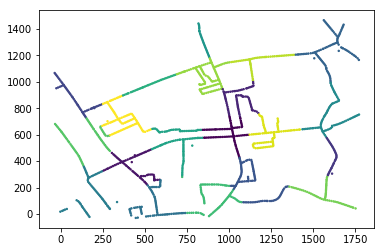

In [33]:
plt.scatter(dataset.X, dataset.Y, c=res, s=2)

In [13]:
from sklearn.model_selection import train_test_split
dataset, test_set = train_test_split(dataset, test_size=0.15, random_state=31)

In [14]:
from torch.utils.data.sampler import Sampler, BatchSampler
class ContrastiveSampler(BatchSampler):
    def __init__(self, batch_size, num_classes, labels, classes_per_batch, batch_per_epoch = 100):
        self.num_classes = num_classes
        self.labels = labels
        self.batch_size = batch_size
        self.classes_per_batch = classes_per_batch
        self.batch_per_epoch = batch_per_epoch

    def __iter__(self):
        num_yielded = 0
        for batch in range(self.batch_per_epoch):
            batch = []
            for i in range(self.classes_per_batch):
                class_id = np.random.randint(low=0, high=self.num_classes)
                batch.extend(np.random.choice(np.where(self.labels==class_id)[0], self.batch_size//self.classes_per_batch))
            yield np.array(batch)
    
    def __len__(self):
        return self.batch_per_epoch

In [15]:
from torch.utils.data.dataset import Dataset
from skimage import io

class ImageDataset(Dataset):
    def __init__(self, dataset, img_folder):
        self.dataset = dataset
        self.img_folder = img_folder
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self, index):
        x, y = dataset.iloc[index][['X', 'Y']].values
        imgs = [io.imread(self.img_folder+"/img%d_%d.png" % (index, i)) for i in range(4)]
        img_tensors = torch.cat([self.to_tensor(i)[None] for i in imgs])
        return (img_tensors, (x,y))

In [16]:
train_loader = torch.utils.data.DataLoader(
    dataset=ImageDataset(dataset, "data"), 
    batch_sampler=ContrastiveSampler(
        batch_size=8,
        num_classes=NUM_CLASSES,
        labels=dataset.clu,
        classes_per_batch=2
    ), 
    shuffle=False
)

In [17]:
class Rbf(torch.nn.Module):
    def __init__(self, gamma=72):
        super(Rbf, self).__init__()
        self.gamma = gamma
    
    def forward(self, obj):
        return torch.exp(-obj/self.gamma)

In [18]:
class Aim(torch.nn.Module):
    def __init__(self, gamma=72):
        super(Aim, self).__init__()
        self.Rbf = Rbf(gamma)

    def forward(self, X, Y):
        distance_mat = torch.sqrt((X[None] - X[:, None])**2 + (Y[None] - Y[:, None])**2)
        return self.Rbf(distance_mat)

In [19]:
class Distances(torch.nn.Module):
    def __init__(self):
        super(Distances, self).__init__()
    
    def forward(self, embedings):
        product = torch.matmul(embedings, torch.transpose(embedings, 0, 1))
        vec_norm = torch.norm(embedings, dim=1, p=2)
        return product/(vec_norm[None] * vec_norm[:, None])

In [20]:
class BatchLoss(torch.nn.Module):
    def __init__(self, gamma=72):
        super(BatchLoss, self).__init__()
        self.distances = Distances()
        self.aim = Aim(gamma)
    
    def forward(self, embedings, X, Y):
        aim_vals = self.aim(X, Y)
        pred_vals = self.distances(embedings)
        print(pred_vals)
        print(aim_vals)
        print((aim_vals-pred_vals)**2)
        return torch.mean((aim_vals-pred_vals)**2)

In [134]:
batch_loss = BatchLoss()
model = EmbedingModel()
def train_epoch(model, optimizer):
    loss_log = []
    model.train()
    for batch_num, (x_batch, (X, Y)) in enumerate(train_loader):
        data = Variable(x_batch)
        var_X = Variable(X.float())
        var_Y = Variable(Y.float())
        optimizer.zero_grad()
        output = model(data)
        loss = batch_loss(output, var_X, var_Y)
        loss.backward()
        optimizer.step()
        loss = loss.data[0]
#         print(loss, end='\r')
        print(loss)
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
#     points = np.array(val_history)
#     plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def train(model, opt, n_epochs):
    train_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt)
#         val_loss = test(model)
        train_log.extend(train_loss)
        steps = 100
#         val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log)

In [135]:
import gc
gc.collect()

67

In [ ]:
# optim.Adam([
#     {'params': model.embeding_model.parameters()},
#     {'params': model.feature_model.parameters(), 'lr': 1e-5}
# ])
opt = torch.optim.Adam([
    {'params': model.embeding_model.parameters()},
    {'params': model.feature_model.parameters(), 'lr': 1e-5}
]
)
train(model, opt, 2)

In [136]:
model.load_state_dict(torch.load("model.pt", map_location=lambda storage, loc: storage))

In [137]:
import pandas as pd
dataset = pd.read_csv("coords.csv", index_col=0)
dataset['X'] = dataset.lat * 111195 - bot_lat * 111195
dataset['Y'] = dataset.lon * 62881.5 - top_lon * 62881.5
dataset.tail(3)

,lat,lon,X,Y
img_id,,,,
1515,55.578379,38.240243,1763.107920,747.032220
1516,55.578444,38.246887,1770.335595,1164.816906
1517,55.578452,38.240321,1771.225155,751.936977


In [21]:
class ImageDataset(Dataset):
    def __init__(self, dataset, img_folder):
        self.dataset = dataset
        self.img_folder = img_folder
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self, index):
        x, y = dataset.iloc[index][['X', 'Y']].values
        imgs = [io.imread(self.img_folder+"/img%d_%d.png" % (index, i)) for i in range(4)]
        img_tensors = torch.cat([self.to_tensor(i)[None] for i in imgs])
        return (img_tensors, (x,y))
tensor_dset=ImageDataset(dataset, "data")

In [152]:
from tqdm import tqdm_notebook as tqdm
calculated = []
model.eval()
for i in tqdm(range(1518)):
    tens, (x, y) = tensor_dset[i]
    gc.collect()
    vec = model(Variable(tens[None])).data.numpy()
    calculated.append((vec, (x, y)))

HBox(children=(IntProgress(value=0, max=1518), HTML(value='')))

In [153]:
def norm(vec):
    return np.sqrt(np.sum(vec**2))

In [159]:
def find_closest(vec_, collected):
    vec = vec_[0]/norm(vec_[0])
    closest_dist = -1
    closest_xy = (0, 0)
    for v2_, xy in collected:
        v2 = v2_[0]/norm(v2_[0])
        d = sum(vec*v2)
        closest_dist = d
        closest_xy = xy
    return closest_xy, closest_dist

In [161]:
def dist(x, y, x_, y_):
    return ((x-x_)**2 + (y-y_)**2)**0.5

In [164]:
train_vecs = [calculated[i] for i in range(1517) if i not in test_set.index]
len(train_vecs)

1289

In [166]:
distances = []
for i in tqdm(test_set.index):
    vec, (x, y) = calculated[i]
    (x_clo, y_clo), closest_dist = find_closest(vec, train_vecs)
    d = dist(x, y, x_clo, y_clo)
    distances.append(d)
#     print(closest_dist, dist(x, y, x_clo, y_clo))

HBox(children=(IntProgress(value=0, max=228), HTML(value='')))

In [167]:
distances = np.array(distances)

In [172]:
np.sum(distances<60)/228

0.5964912280701754

In [48]:
sample = ImageDataset(dataset, 'data')[1000][0]

In [49]:
sample.shape

torch.Size([4, 3, 224, 224])

In [44]:
def img_to_plot(img):
    return np.einsum('ijk->jki', img.numpy())

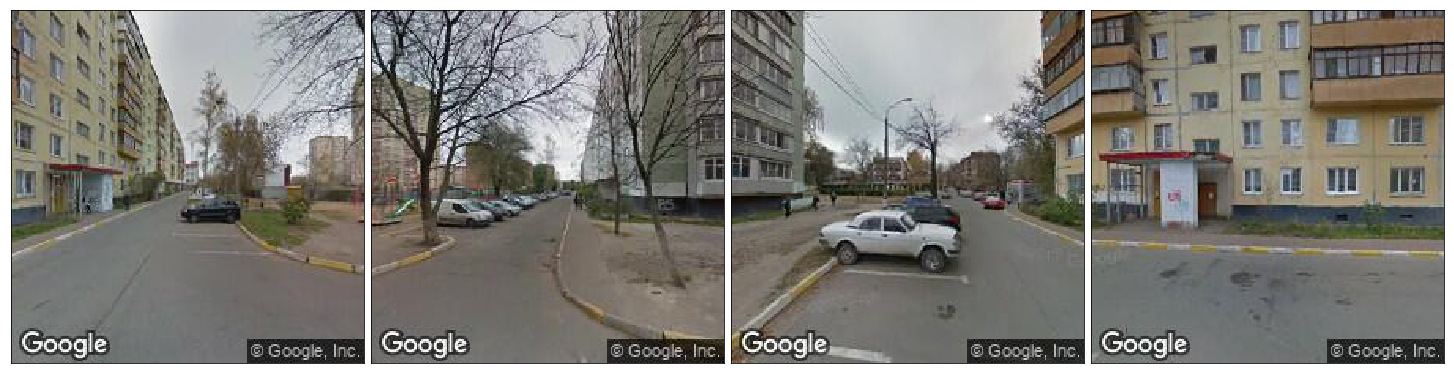

In [51]:
plt.figure(figsize=(20,10))
for i, img in enumerate(sample):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
    plt.imshow(img_to_plot(img))
    

([], <a list of 0 Text yticklabel objects>)

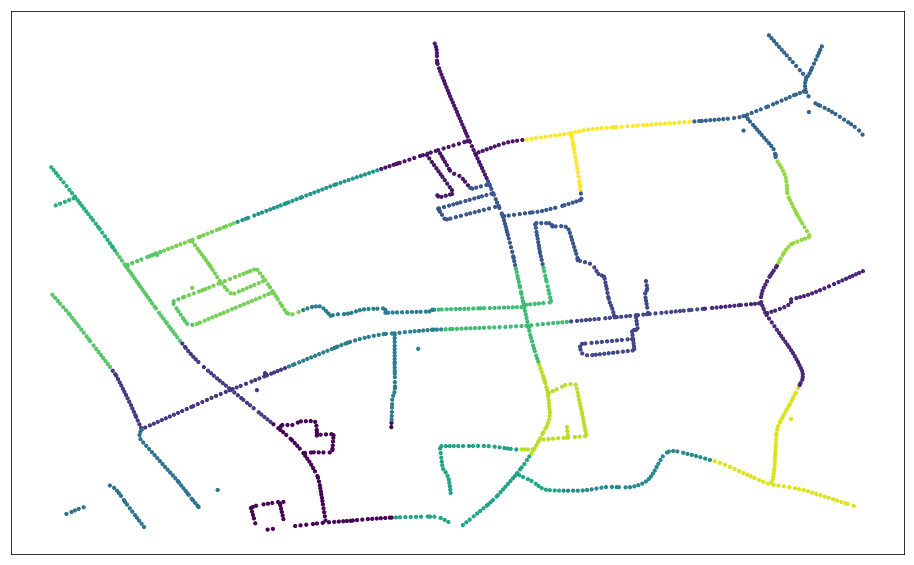

In [107]:
plt.figure(figsize=(16,10))

plt.scatter(dataset.X, dataset.Y, marker='o', s=10, c=res)
plt.xticks([])
plt.yticks([])

In [35]:
dataset.shape

(1518, 5)

In [36]:
closest = []

In [37]:
def row_dist(r1, r2):
    return np.sqrt((r1['X']-r2['X'])**2 + (r1['Y']-r2['Y'])**2)

In [38]:
for i, r1 in dataset.iterrows():
    best = float('inf')
    for j, r2 in dataset.iterrows():
        if i == j:
            continue
        best = min(best, row_dist(r1, r2))
    closest.append(best)

In [39]:
closest = np.array(closest)

In [40]:
np.argmax(closest)

255

In [42]:
plt.ims

63.29187874180836

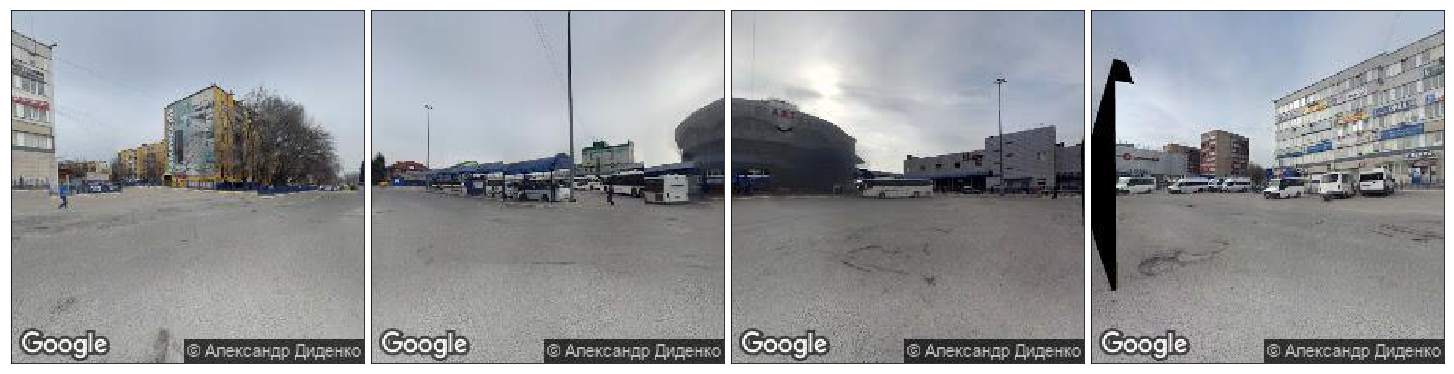

In [45]:
sample = ImageDataset(dataset, 'data')[255][0]
plt.figure(figsize=(20,10))
for i, img in enumerate(sample):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
    plt.imshow(img_to_plot(img))